In [11]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

from jax import jit, tree_map
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook, Array
from copy import deepcopy
from typing import Optional
import numpy as np
from gpjax.base import meta_leaves
from jax.flatten_util import ravel_pytree
from jax.stages import Wrapped
import warnings
import optax as ox
from tqdm import tqdm

import matplotlib.pyplot as plt

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx
    from gpjax.kernels import Constant, Linear, RBF, Periodic, PoweredExponential

key = jr.PRNGKey(42)

In [3]:
class Node:
    def __init__(
        self,
        posterior: gpx.gps.AbstractPosterior,
        max_log_likelihood: Optional[float] = None,
        n_data: Optional[int] = None,
        parent=Optional["Node"],
    ):
        self.children = []
        self.parent = parent

        self.update(
            posterior,
            max_log_likelihood,
            n_data,
        )

    def update(
        self,
        posterior: gpx.gps.AbstractPosterior,
        max_log_likelihood: Optional[float] = None,
        n_data: Optional[int] = None,
    ):
        self.posterior = posterior

        self.n_parameter = sum(
            leaf[0]["trainable"]
            for leaf in meta_leaves(posterior)
            if isinstance(leaf[0], dict)
        )  # number of trainable parameter

        if n_data is not None:
            self.n_data = np.log(n_data)

        if max_log_likelihood is not None:
            self.max_log_likelihood = max_log_likelihood
            if self.n_data is not None:
                self.bic = self.n_parameter * self.n_data - 2 * self.max_log_likelihood

    def add_child(
        self,
        node: "Node",
    ):
        self.children.append(node)


class KernelSearch:
    def __init__(
        self,
        kernel_library: list[gpx.kernels.AbstractKernel],
        data: gpx.Dataset,
        obs_stddev: float | Array = 1,
        fit_obs_stddev: bool = False,
        likelihood: Optional[gpx.likelihoods.AbstractLikelihood] = None,
        objective: Optional[gpx.objectives.AbstractObjective | Wrapped] = None,
        mean_function: Optional[gpx.mean_functions.AbstractMeanFunction] = None,
        root_kernel: Optional[gpx.kernels.AbstractKernel] = None,
        fitting_mode: str = "scipy",
        num_iters: int = 1000,
        parallelise: bool = True,
        n_cores: int = 8,
        verbosity: int = 1,
    ):
        """_summary_

        Parameters
        ----------
        kernel_library : list[gpx.kernels.AbstractKernel]
            _description_
        data : gpx.Dataset
            _description_
        obs_stddev : float | Array, optional
            _description_, is ignored if custom likelihood is given, by default 1
        fit_obs_stddev : bool, optional
            _description_, is ignored if custom likelihood is given, by default False
        likelihood : Optional[gpx.likelihoods.AbstractLikelihood], optional
            _description_, by default None, which defaults to the Gaussian likelihood with standard deviation given by obs_stddev.
        objective : Optional[gpx.objectives.AbstractObjective  |  Wrapped], optional
            _description_, by default None, which defaults to the jit-compiled leave-one-out predictive probability 
        mean_function : Optional[gpx.mean_functions.AbstractMeanFunction], optional
            _description_, by default None, which sets the mean to zero
        root_kernel : gpx.kernels.AbstractKernel
        _description_
        fitting_mode : str, optional
            _description_, by default "scipy"
        num_iters : int, optional
            _description_, by default 1000
        parallelise : bool, optional
            _description_, by default True
        n_cores : int, optional
            _description_, by default 8
        verbosity : int, optional
            _description_, by default 1
        """
        if isinstance(obs_stddev, float):
            obs_stddev = jnp.array(obs_stddev)
        if likelihood is None:
            likelihood = gpx.likelihoods.Gaussian(
                num_datapoints=data.n, obs_stddev=obs_stddev
            )
            likelihood = likelihood.replace_trainable(obs_stddev=fit_obs_stddev)  # type: ignore
        if objective is None:
            objective = jit(gpx.objectives.ConjugateLOOCV(negative=True))
        if mean_function is None:
            mean_function = gpx.mean_functions.Zero()

        self.likelihood = likelihood
        self.objective = objective
        self.data = data
        self.kernel_library = kernel_library

        self.fitting_mode = fitting_mode
        self.num_iters = num_iters

        self.parallelise = parallelise
        self.n_cores = n_cores

        self.verbosity = verbosity

        self.root = [
            Node(
                likelihood
                * gpx.gps.Prior(
                    mean_function=mean_function,
                    kernel=self._const_kernel() * kernel,
                )
            )
            for kernel in (kernel_library if root_kernel is None else [root_kernel])
        ]


    @staticmethod
    def _const_kernel(trainable=False):
        return Constant(constant=jnp.array(1.0)).replace_trainable(constant=trainable)  # type: ignore

    def fit(self, posterior) -> tuple[gpx.gps.AbstractPosterior, float]:
        if self.fitting_mode == "scipy":
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                optimized_posterior, history = gpx.fit_scipy(
                    model=posterior,
                    objective=self.objective,
                    train_data=self.data,
                    max_iters=self.num_iters,
                    verbose=self.verbosity >= 2
                )
        elif self.fitting_mode == "adam":
            static_tree = tree_map(lambda x: not x, posterior.trainables)
            optim = ox.chain(
                ox.adamw(learning_rate=3e-4),
                ox.masked(
                    ox.set_to_zero(),
                    static_tree,
                ),
            )
            optimized_posterior, history = gpx.fit(
                model=posterior,
                objective=self.objective,
                train_data=self.data,
                optim=optim,
                key=key,
                num_iters=self.num_iters,
                verbose=self.verbosity >= 2
            )
        else:
            raise ValueError("'fitting_mode' must be 'scipy' or 'adam'.")

        max_log_likelihood = -float(history[-1])
        return optimized_posterior, max_log_likelihood

    def expand_node(self, node):
        for kernel_operation in [gpx.kernels.ProductKernel, gpx.kernels.SumKernel]:
            for ker in self.kernel_library:
                kernel = deepcopy(node.posterior.prior.kernel)

                new_kernel = deepcopy(ker)  # type: ignore
                if kernel_operation == gpx.kernels.SumKernel:
                    # create new additive term with tracer constant
                    # the first kernel in the new term has a trainable constant
                    new_kernel = gpx.kernels.ProductKernel(kernels=[self._const_kernel(), new_kernel])  # type: ignore
                if kernel_operation == gpx.kernels.ProductKernel:
                    # further kernels have variance fixed, so that we only have one constant
                    try:
                        new_kernel = new_kernel.replace_trainable(variance=False)  # type: ignore
                    except ValueError:
                        pass

                composite_kernel = kernel_operation(kernels=[kernel, new_kernel])  # type: ignore

                new_prior = gpx.gps.Prior(
                    mean_function=node.posterior.prior.mean_function,
                    kernel=composite_kernel,
                )
                new_posterior = self.likelihood * new_prior
                node.add_child(Node(new_posterior, parent=node))

    def compute_layer(self, layer, current_depth):
        if self.verbosity == 1:
            for node in tqdm(layer, desc=f"Fitting Layer {current_depth +1}"):
                node.update(*self.fit(node.posterior), self.data.n)
        else:
            [node.update(*self.fit(node.posterior), self.data.n) for node in layer]

    def select_top_nodes(self, layer, bic_threshold, n_leafs):
        sorted_tuple = sorted((node.bic, node) for node in layer)
        # return first n_leafs nodes
        top_nodes = [node for _, node in sorted_tuple][:n_leafs]
        # filter for bic threshold
        top_nodes = [node for node in top_nodes if node.bic < bic_threshold]
        if top_nodes:
            self.best_model = top_nodes[0]
        return top_nodes

    def expand_layer(self, layer):
        next_layer = []
        for node in layer:
            self.expand_node(node)
            next_layer.extend(node.children)
        return next_layer

    def search(
        self,
        depth: int = 10,
        n_leafs: int = 3,
    ):
        layer = self.root

        current_depth = 0
        bic_threshold = np.inf
        for current_depth in range(depth):
            self.compute_layer(layer, current_depth)
            if current_depth == 0:
                best_model = sorted((node.bic, node) for node in layer)[0][1]

            current_bics = sorted([node.bic for node in layer])
            if self.verbosity >= 1:
                print(f"Layer {current_depth+1} || Current BICs: {current_bics}")

            if current_bics[0] > bic_threshold:
                if self.verbosity >= 1:
                    print("No more improvements found! Terminating early..\n")
                    break

            layer = self.select_top_nodes(layer, bic_threshold, n_leafs)
            bic_threshold = current_bics[0]  # min bic of current layer
            best_model = layer[0]
            layer = self.expand_layer(layer)

        if self.verbosity >= 1:
            print(f"Terminated on layer: {current_depth+1}.")
            print(f"Final log likelihood: {best_model.max_log_likelihood}")
            print(f"Final number of model paramter: {best_model.n_parameter}")
        return best_model.posterior

# TESTING

In [4]:
# data
n = 100
noise = 0.3

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [5]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    PoweredExponential(power=jnp.array(0.8)),
]  # default powered exponential has infinite parameter for some reason

In [6]:
# rescale input! (i.e. if mean func is zero, should be centered at zero, maybe rather do that in data fit rountine though)

In [7]:
tree = KernelSearch(
    kernel_library,
    data=D,
    obs_stddev=0.3,
    verbosity=1,
)

model = tree.search(depth=5, n_leafs=3)

Fitting Layer 1: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


Layer 1 || Current BICs: [45.179920166104345, 73.87658262301538, 78.48175281305917, 307.24806717469136, 1171.2001302012027]


Fitting Layer 2: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]

Layer 2 || Current BICs: [49.784717339963755, 49.7850903520536, 49.78509058114803, 53.4911595945735, 54.38988560656452, 54.38988769798024, 54.38989865668063, 54.3902611064575, 58.49777227622251, 58.995055792493936, 58.99507131459578, 66.3996029461207, 71.00087352857292, 78.4817528089967, 78.52125741841078, 78.63514746704516, 83.08692299737453, 83.08692299967426, 83.12642746887882, 83.12642765316464, 83.23964130956047, 87.65849638288176, 87.69209319373448, 87.73159765678182, 87.73159767723709, 92.26366657301116, 92.33676792264897, 113.93587662694766, 160.6658596270523, 165.2710298951036]
No more improvements found! Terminating early..

Terminated on layer: 2.
Final log likelihood: -17.984789897064083
Final number of model paramter: 2


In [9]:
latent_dist = model.predict(xtest, train_data=D)
predictive_dist = model.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()


In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

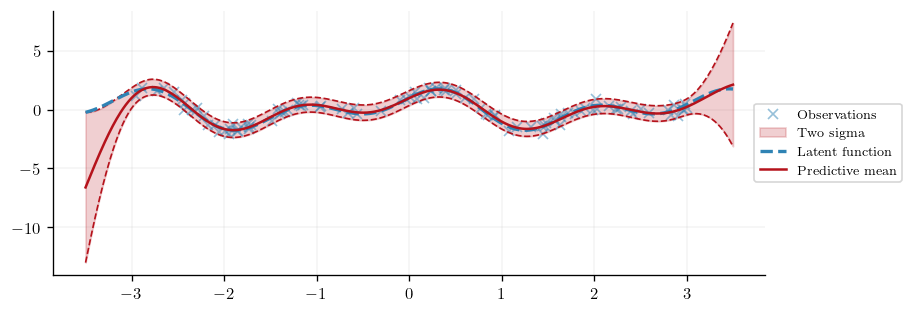

In [16]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
)
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))